In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os import path
from collections import defaultdict

import sys
sys.path.insert(0, path.abspath(path.join(path.curdir, '../src')))

%matplotlib notebook

In [2]:
# READ DATA: Blade landings 

blade_landings= pd.read_csv('blade_landing_helihoist_sbitroot.txt')

# make epoch index of dataframe and convert epoch into readable dates
blade_landings.epoch_land= blade_landings.epoch_land.apply(lambda x: pd.to_datetime(x, unit= 's', utc=True))

# convert blade landings of turbine 8 into readable dates
blade_landing1= pd.to_datetime(1.571127e+09	, unit='s', utc=True)
blade_landing2= pd.to_datetime(1.571154e+09, unit='s', utc=True)
blade_landing3= pd.to_datetime(1.571188e+09, unit='s', utc=True)

landings = (blade_landing1, blade_landing2, blade_landing3)

In [3]:
# Read csv files of GPS Data: turbine 8

# sbitroot
gps_sbitroot_tb8= pd.read_csv('turbine-08_sbitroot_tom_gps.csv')
gps_sbitroot_tb8.epoch= pd.to_datetime(gps_sbitroot_tb8.epoch, unit= 's', utc=True)
gps_sbitroot_tb8.set_index('epoch', inplace=True)

# sbittip
gps_sbittip_tb8= pd.read_csv('turbine-08_sbittip_tom_gps.csv')
gps_sbittip_tb8.epoch= pd.to_datetime(gps_sbittip_tb8.epoch, unit= 's', utc=True)
gps_sbittip_tb8.set_index('epoch', inplace=True)

# helihoist
gps_helih_tb8= pd.read_csv('turbine-08_helihoist-1_tom_gps.csv')
gps_helih_tb8.epoch= pd.to_datetime(gps_helih_tb8.epoch, unit= 's', utc=True)
gps_helih_tb8.set_index('epoch', inplace=True)

In [4]:
# Find blade installation period in data

hub_height = 90 # hub height = 90m

# smoothing the time series: cut the outliers and find the 20min mean value
hh, sr, st = (gps_helih_tb8.altitude.resample('1s').mean().rolling('20min').mean(), gps_sbitroot_tb8.altitude.resample('1s').mean().rolling('20min').mean(), gps_sbittip_tb8.altitude.resample('1s').mean().rolling('20min').mean())

hh_sbi = hh[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]
sr_sbi = sr[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]
st_sbi = st[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]

# determine start and end period of single blade installations
inst_period = sr_sbi[sr_sbi.index.to_series().diff() > pd.to_timedelta(60, unit='s')].index.to_list()
inst_period.insert(0, hh_sbi.index[0])
inst_period.insert(len(inst_period), hh_sbi.index[-1])
sbi_indices = list()

for i in range(len(inst_period) - 1):
    sbi_indices.append((inst_period[i], hh_sbi[inst_period[i]:inst_period[i+1]].index[-2]))

<IPython.core.display.Javascript object>


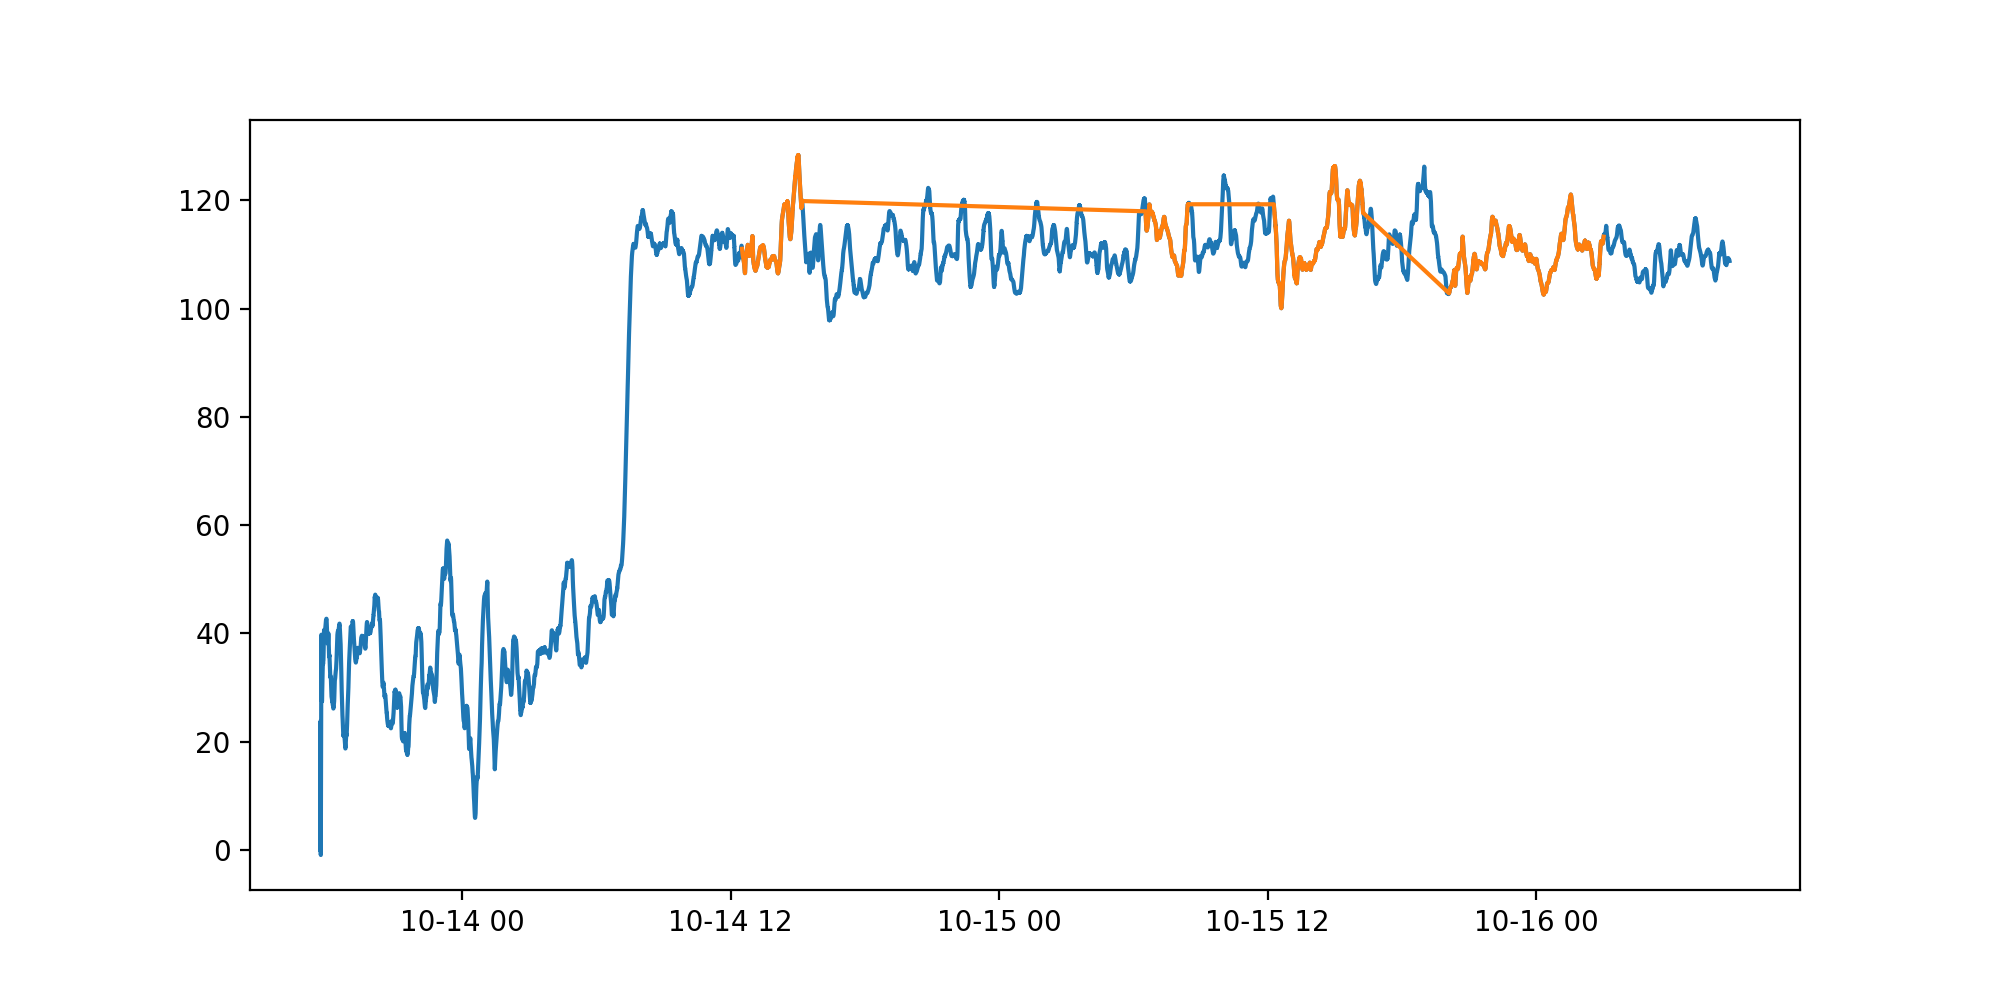

In [5]:
plt.figure(figsize = (10,5))
plt.plot(hh)
plt.plot(hh_sbi)

In [6]:
# concatenate csv data of helihoist 

path_hh = r'/Users/lenastroer/Python_Lokal/MasterThese/tb8/Blade_Landings/Helihoist'
hh_files = glob(path_hh + "/*.csv")

hh_data_tb8 = []

for filename in hh_files:
    hh_df = pd.read_csv(filename, index_col=None, header=0)
    hh_data_tb8.append(hh_df)

hh_frame = pd.concat(hh_data_tb8, axis=0, ignore_index=True)

hh_frame.epoch= pd.to_datetime(hh_frame.epoch, unit= 's', utc=True)
hh_frame.set_index('epoch', inplace=True)
hh_frame = hh_frame.sort_index()

# concatenate csv data of sbitroot

path_sbitroot = r'/Users/lenastroer/Python_Lokal/MasterThese/tb8/Blade_Landings/sbitroot'
sbitroot_files = glob(path_sbitroot + "/*.csv")

sbitroot_data_tb8 = []

for filename in sbitroot_files:
    sbitroot_df = pd.read_csv(filename, index_col=None, header=0)
    sbitroot_data_tb8.append(sbitroot_df)

sbitroot_frame = pd.concat(sbitroot_data_tb8, axis=0, ignore_index=True)

sbitroot_frame.epoch= pd.to_datetime(sbitroot_frame.epoch, unit= 's', utc=True)
sbitroot_frame.set_index('epoch', inplace=True)
sbitroot_frame = sbitroot_frame.sort_index()

# concatenate csv data of sbittip

path_sbittip = r'/Users/lenastroer/Python_Lokal/MasterThese/tb8/Blade_Landings/sbittip'
sbittip_files = glob(path_sbittip + "/*.csv")

sbittip_data_tb8 = []

for filename in sbittip_files:
    sbittip_df = pd.read_csv(filename, index_col=None, header=0)
    sbittip_data_tb8.append(sbittip_df)

sbittip_frame = pd.concat(sbittip_data_tb8, axis=0, ignore_index=True)

sbittip_frame.epoch= pd.to_datetime(sbittip_frame.epoch, unit= 's', utc=True)
sbittip_frame.set_index('epoch', inplace=True)
sbittip_frame = sbittip_frame.sort_index()

In [7]:
# Filter out outliers from acceleration measurement

# SBIT root 
median = sbitroot_frame.loc[sbitroot_frame['acc_x']<10, 'acc_x'].median()
neg= -4
sbitroot_frame['acc_x'] = np.where(sbitroot_frame["acc_x"] >4, median,sbitroot_frame['acc_x'])
sbitroot_frame['acc_x'] = np.where(sbitroot_frame["acc_x"] < neg, median,sbitroot_frame['acc_x'])

# SBIT tip

sbittip_frame['acc_x'] = np.where(sbittip_frame["acc_x"] >4, median,sbittip_frame['acc_x'])
sbittip_frame['acc_x'] = np.where(sbittip_frame["acc_x"] < neg, median,sbittip_frame['acc_x'])

<IPython.core.display.Javascript object>


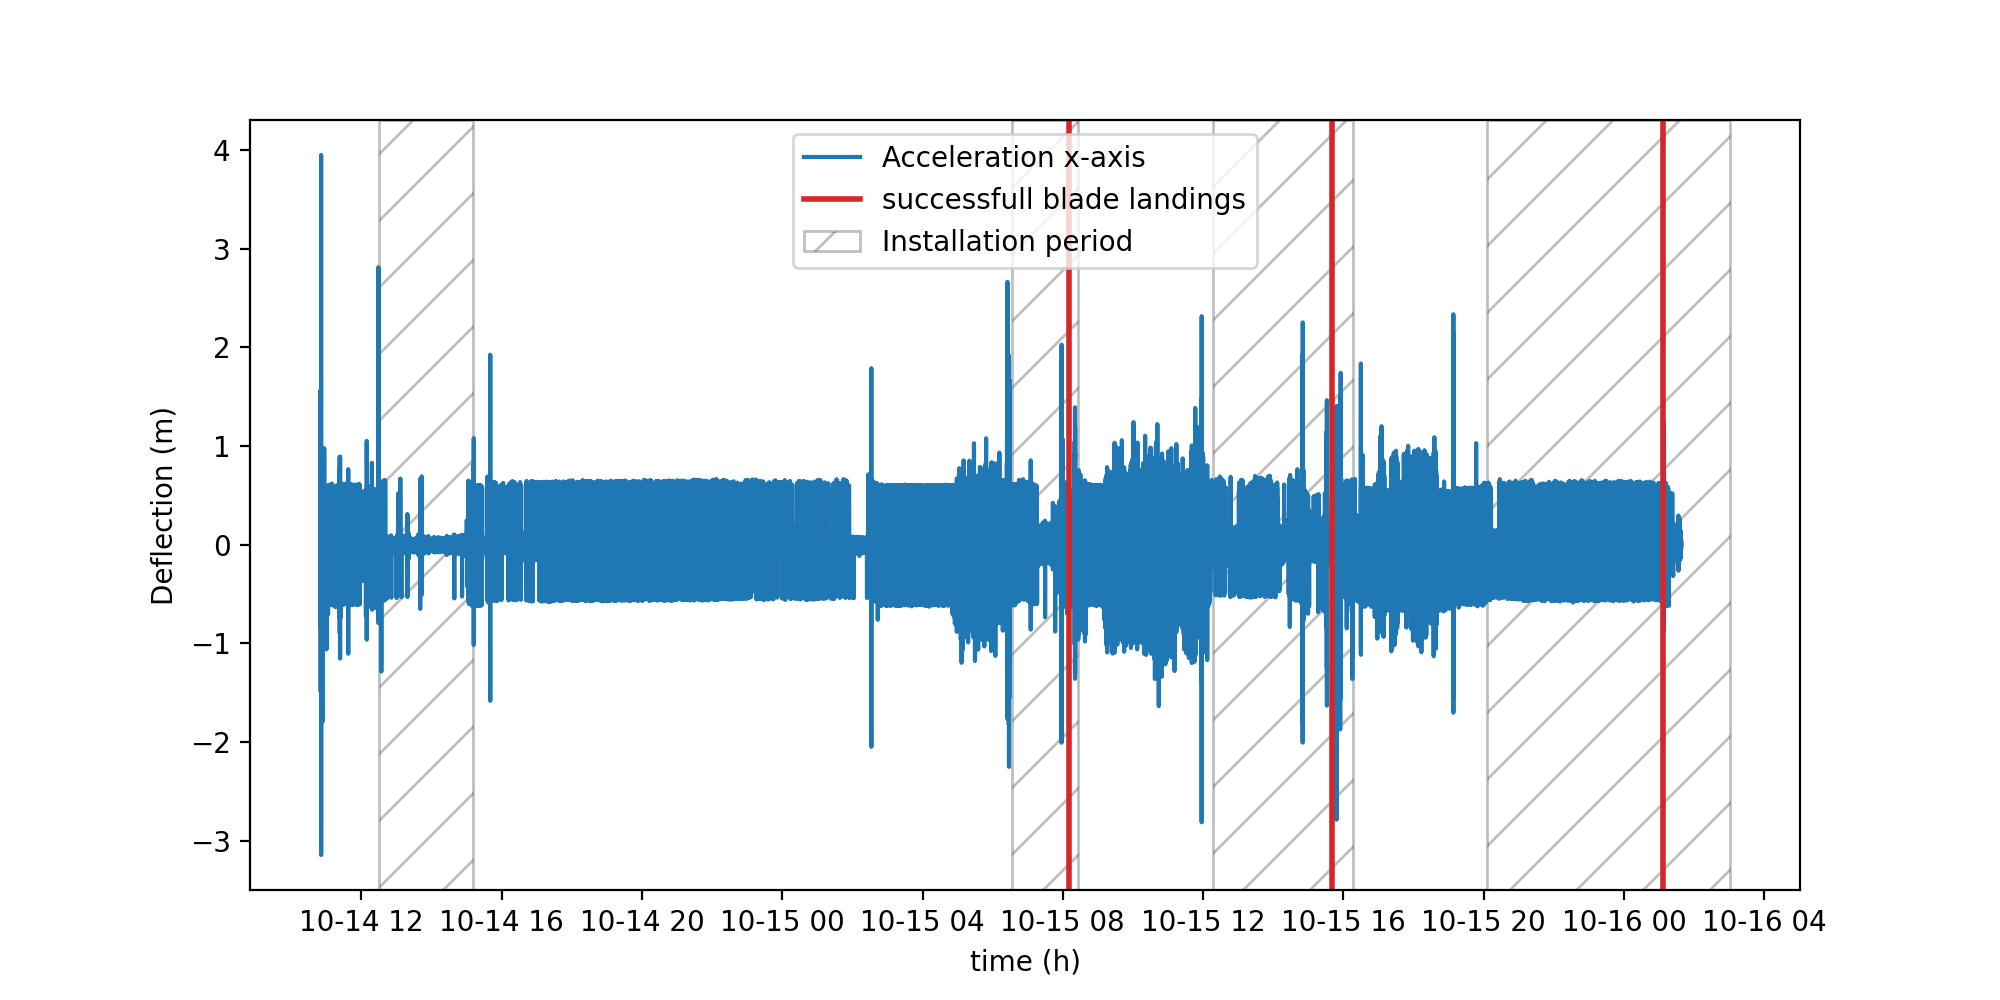

Text(0, 0.5, 'Deflection (m)')

In [8]:
plt.figure(figsize=(10,5))
plt.plot(sbitroot_frame.acc_x, label='Acceleration x-axis')
#plt.plot(sbitroot_frame.acc_y, label='Acceleration y-axis')
plt.axvspan(xmin=sbi_indices[0][0], xmax=sbi_indices[0][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
plt.axvspan(xmin=sbi_indices[1][0], xmax=sbi_indices[1][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation period')   
plt.axvspan(xmin=sbi_indices[2][0], xmax=sbi_indices[2][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
plt.axvspan(xmin=sbi_indices[3][0], xmax=sbi_indices[3][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')
plt.axvline(x=blade_landing1, color='tab:red', linewidth=2, label='successfull blade landings')
plt.axvline(x=blade_landing2, color='tab:red', linewidth=2)
plt.axvline(x=blade_landing3, color='tab:red', linewidth=2)
plt.legend()
plt.xlabel('time (h)')
plt.ylabel('Deflection (m)')

<IPython.core.display.Javascript object>


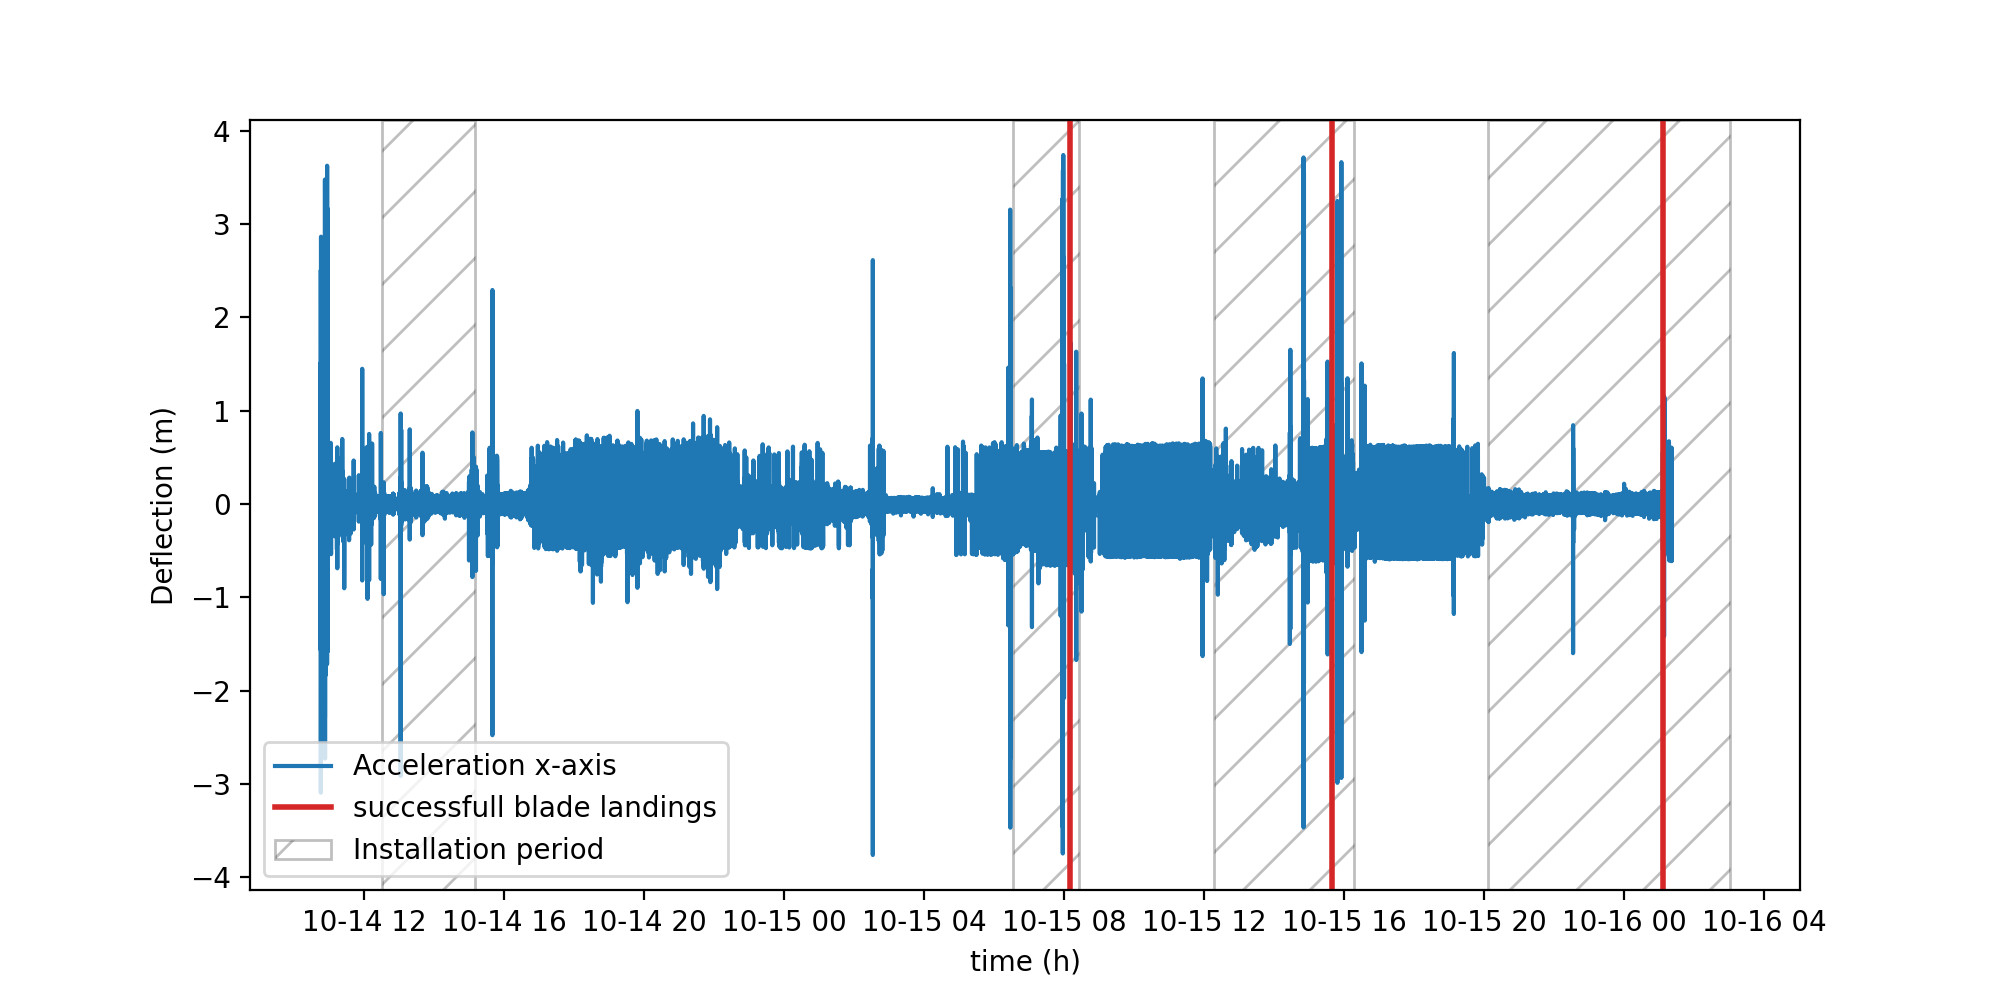

Text(0, 0.5, 'Deflection (m)')

In [9]:
plt.figure(figsize=(10,5))
plt.plot(sbittip_frame.acc_x, label='Acceleration x-axis')
#plt.plot(sbitroot_frame.acc_y, label='Acceleration y-axis')
plt.axvspan(xmin=sbi_indices[0][0], xmax=sbi_indices[0][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
plt.axvspan(xmin=sbi_indices[1][0], xmax=sbi_indices[1][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation period')   
plt.axvspan(xmin=sbi_indices[2][0], xmax=sbi_indices[2][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
plt.axvspan(xmin=sbi_indices[3][0], xmax=sbi_indices[3][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')
plt.axvline(x=blade_landing1, color='tab:red', linewidth=2, label='successfull blade landings')
plt.axvline(x=blade_landing2, color='tab:red', linewidth=2)
plt.axvline(x=blade_landing3, color='tab:red', linewidth=2)
plt.legend()
plt.xlabel('time (h)')
plt.ylabel('Deflection (m)')

In [10]:
# Find blade installation period in data

acc_threshold = 0.5 # acceleration threshold (m/s^2)
acc_threshold_neg= -0.5
sbitroot_installation = pd.DataFrame()

for start, end in sbi_indices:
    #sbitroot_installation = sbitroot_frame[start:end]
    sbitroot_installation = sbitroot_installation.append(sbitroot_frame[start:end])

# HIER IST DER FEHLER 
sbitroot_acc = sbitroot_installation.acc_x[(sbitroot_installation.acc_x < acc_threshold) & (sbitroot_installation.acc_x > acc_threshold_neg)]

# determine independent blade movement periods
ind_period = sbitroot_acc[sbitroot_acc.index.to_series().diff() > pd.to_timedelta(60, unit='s')].index.to_list()
ind_period.insert(0, sbitroot_acc.index[0])
ind_period.insert(len(ind_period), sbitroot_acc.index[-1])
ind_period_indices = list()

for i in range(len(ind_period) -1 ):
    gaps = sbitroot_acc[ind_period[i]:ind_period[i+1]].index.to_series().diff() 
    ind_period_indices.append((ind_period[i], ind_period[i+1]-gaps[ind_period[i+1]]))


In [11]:
print(ind_period_indices)

[(Timestamp('2019-10-14 12:30:18.006000128+0000', tz='UTC'), Timestamp('2019-10-14 15:10:42.984000+0000', tz='UTC')), (Timestamp('2019-10-15 06:32:25.005000192+0000', tz='UTC'), Timestamp('2019-10-15 08:26:28.973999872+0000', tz='UTC')), (Timestamp('2019-10-15 12:16:23.007000064+0000', tz='UTC'), Timestamp('2019-10-15 16:16:32.984999936+0000', tz='UTC')), (Timestamp('2019-10-15 20:06:10.023000064+0000', tz='UTC'), Timestamp('2019-10-16 01:37:53.703000064+0000', tz='UTC'))]


<IPython.core.display.Javascript object>


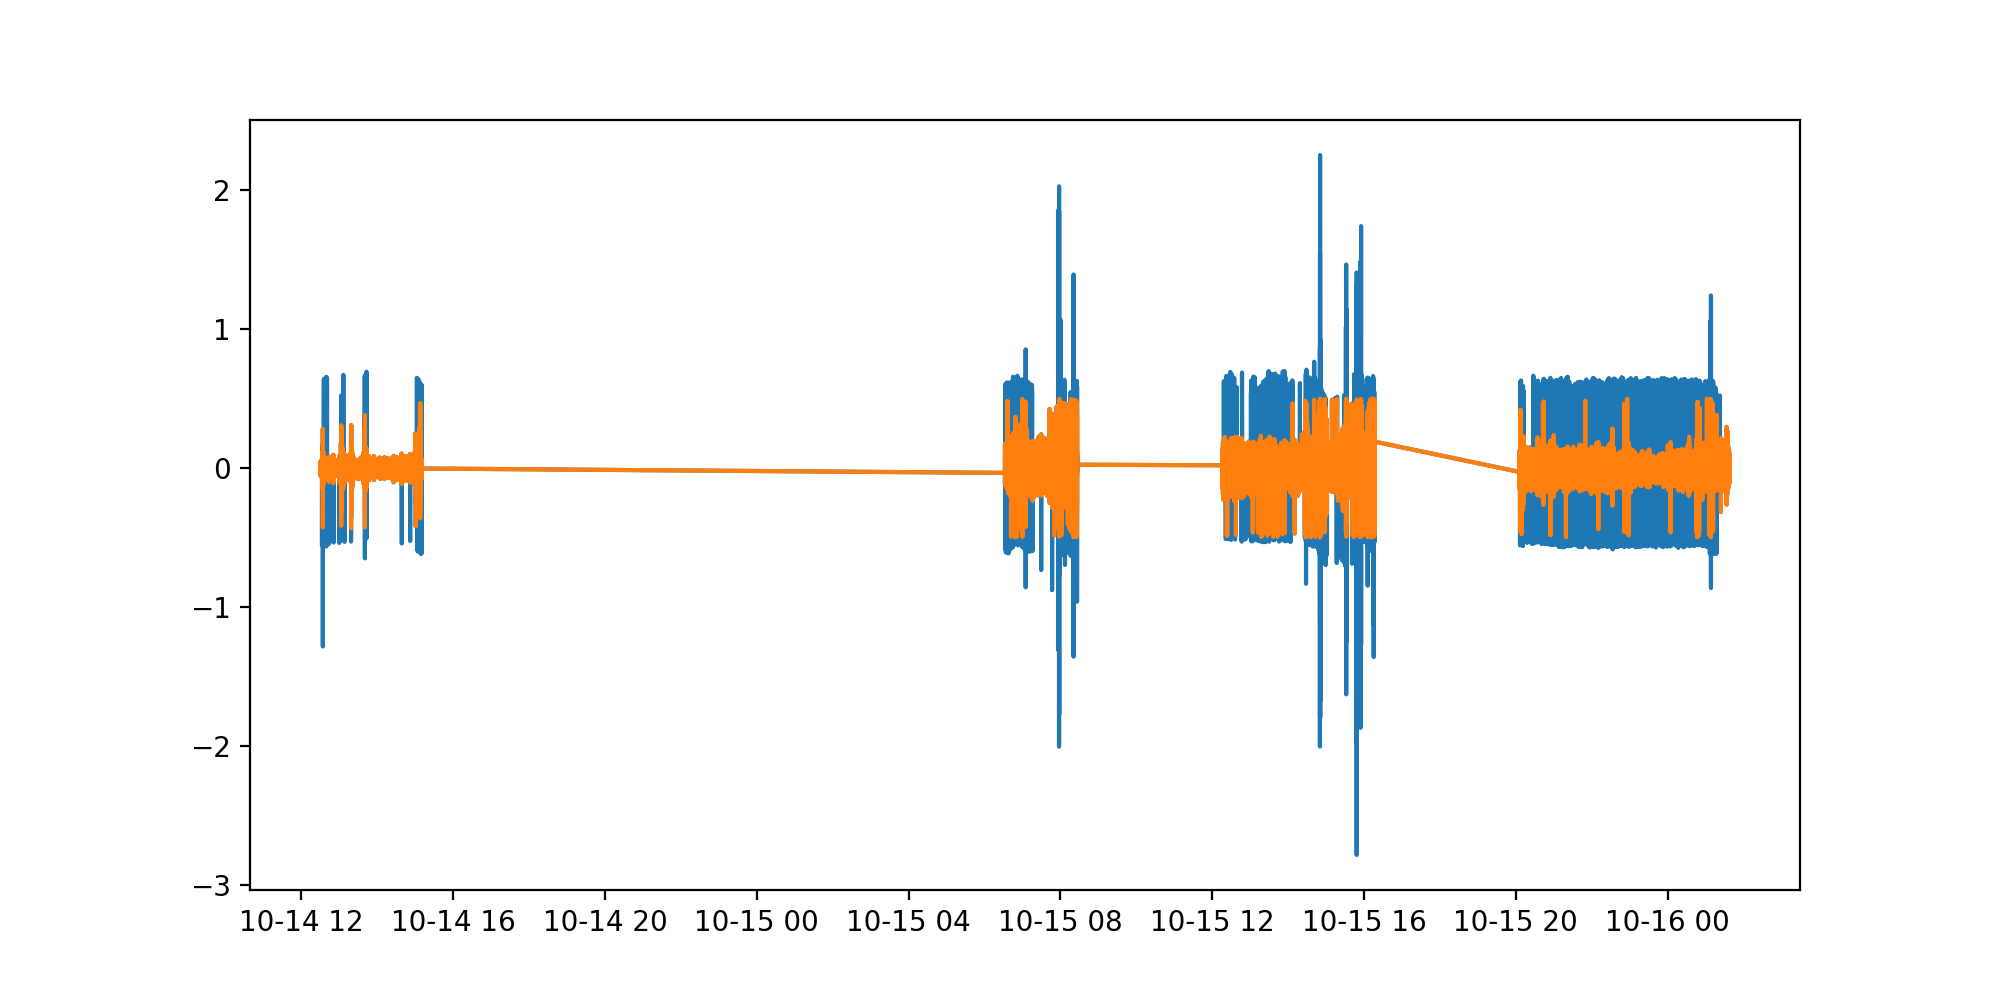

In [12]:
plt.figure(figsize=(10,5))
#plt.plot(sbitroot_frame.acc_x)
plt.plot(sbitroot_installation.acc_x)
plt.plot(sbitroot_acc)

<IPython.core.display.Javascript object>


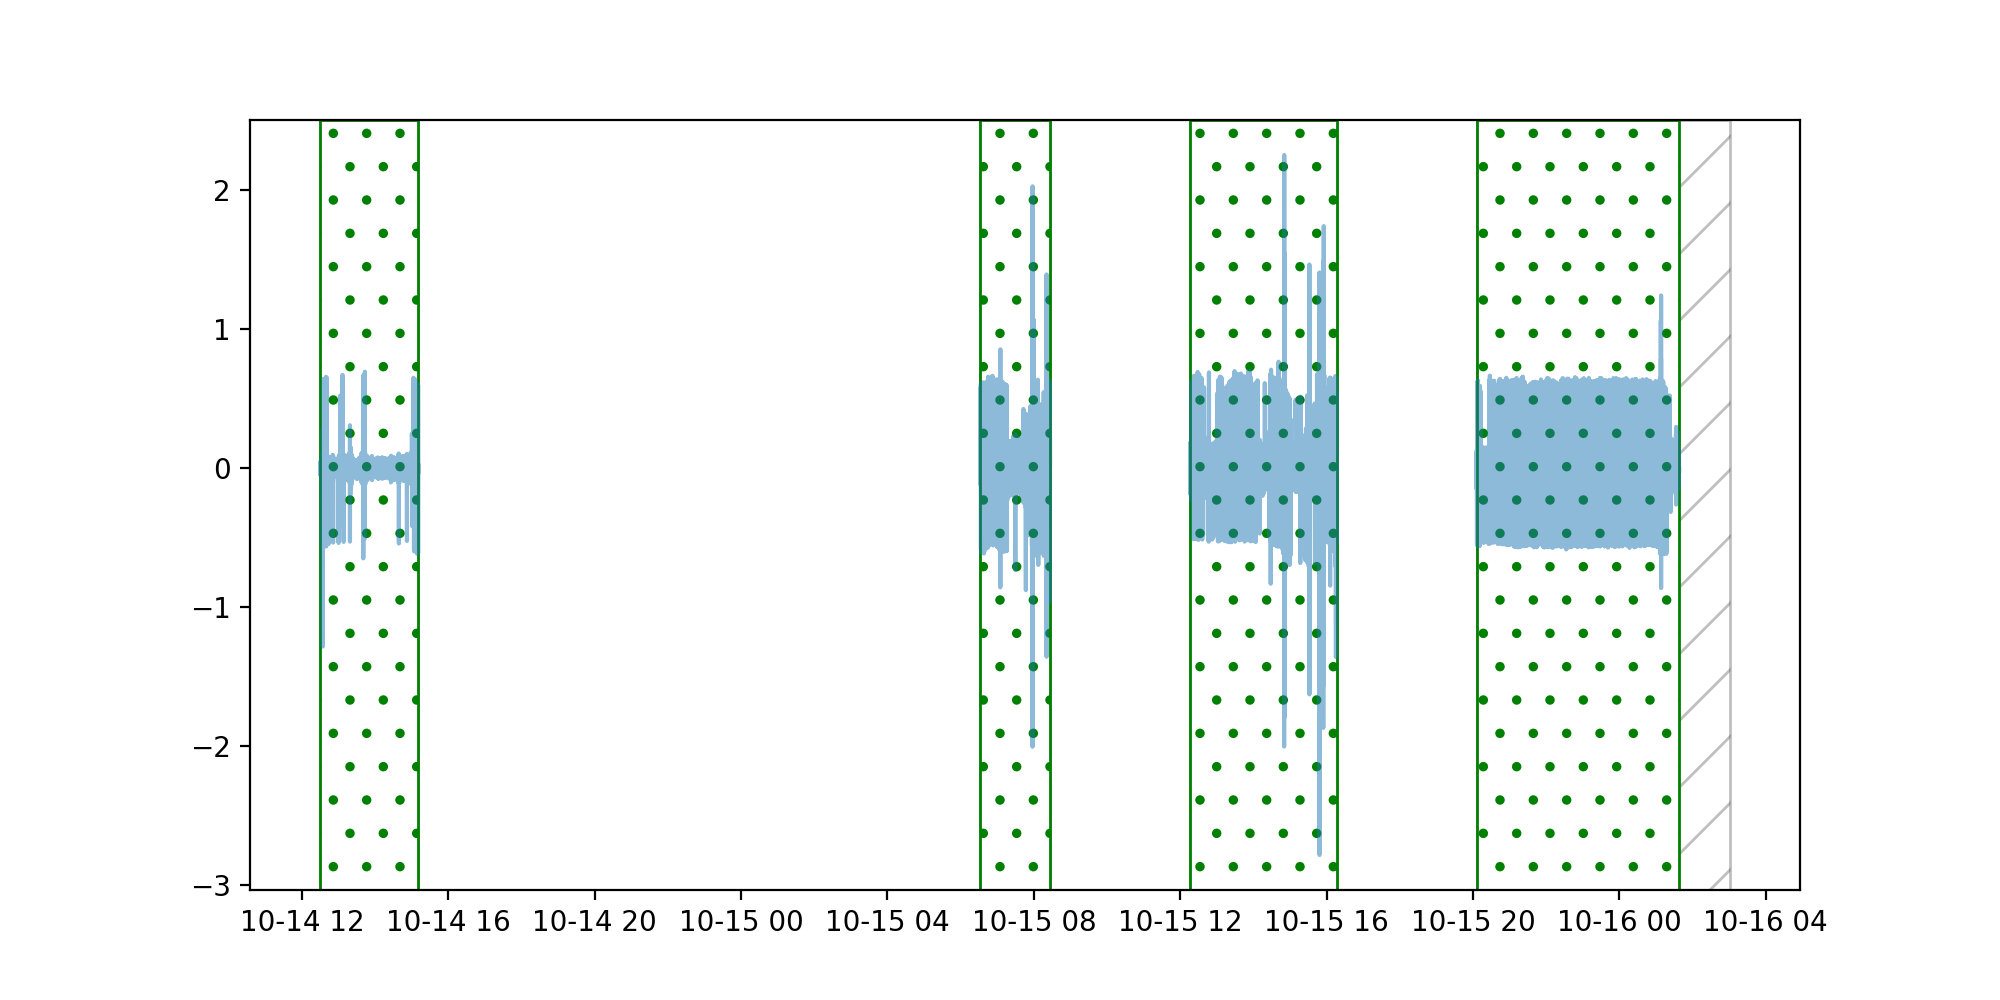

In [13]:
plt.figure(figsize=(10,5))

# plot installation times (SBIT altitude > 90m)
plt.axvspan(xmin=sbi_indices[0][0], xmax=sbi_indices[0][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
plt.axvspan(xmin=sbi_indices[1][0], xmax=sbi_indices[1][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation period')   
plt.axvspan(xmin=sbi_indices[2][0], xmax=sbi_indices[2][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
plt.axvspan(xmin=sbi_indices[3][0], xmax=sbi_indices[3][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')

# plot accelerations during installation times
for start, end in sbi_indices:
    #sbitroot_frame[start:end]
    plt.plot(sbitroot_frame[start:end].acc_x, color='tab:blue', alpha= 0.5)

# plot independent oscillations during installation times
for i in range(len(ind_period_indices)):
    for j in range (0,1):
        ind_period_indices[i:j]
        plt.axvspan(xmin=ind_period_indices[i][j], xmax=ind_period_indices[i][j+1], hatch='.', facecolor='white', edgecolor='g') 
    
#plt.axvspan(xmin=ind_period_indices[0][0], xmax=ind_period_indices[0][1], hatch='/', facecolor='white', edgecolor='g') 